# Le sujet

Le Bird Song Dataset sur Kaggle est une collection de sons d'oiseaux, souvent utilisée pour des projets de classification audio et d'apprentissage automatique. Ce jeu de données contient des enregistrements audio de chants d'oiseaux de différentes espèces, ce qui en fait un excellent outil pour les chercheurs et les développeurs qui souhaitent travailler sur des tâches d'analyse de données audio, telles que la reconnaissance des espèces d'oiseaux par leur chant.

# Téléchargement du dataset sur kaggle

In [2]:
import kaggle

# Télécharger le dataset
!kaggle datasets download vinayshanbhag/bird-song-data-set

Dataset URL: https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set
License(s): other




  0%|          | 0.00/2.09G [00:00<?, ?B/s]
  0%|          | 1.00M/2.09G [00:01<53:43, 695kB/s]
  0%|          | 2.00M/2.09G [00:01<26:44, 1.40MB/s]
  0%|          | 3.00M/2.09G [00:01<17:20, 2.15MB/s]
  0%|          | 4.00M/2.09G [00:02<12:04, 3.09MB/s]
  0%|          | 5.00M/2.09G [00:02<09:30, 3.92MB/s]
  0%|          | 6.00M/2.09G [00:02<07:42, 4.84MB/s]
  0%|          | 7.00M/2.09G [00:02<06:52, 5.41MB/s]
  0%|          | 8.00M/2.09G [00:02<06:00, 6.20MB/s]
  0%|          | 9.00M/2.09G [00:02<05:46, 6.44MB/s]
  1%|          | 11.0M/2.09G [00:02<05:00, 7.42MB/s]
  1%|          | 12.0M/2.09G [00:03<04:45, 7.80MB/s]
  1%|          | 13.0M/2.09G [00:03<04:31, 8.22MB/s]
  1%|          | 14.0M/2.09G [00:03<04:30, 8.22MB/s]
  1%|          | 15.0M/2.09G [00:03<04:26, 8.35MB/s]
  1%|          | 16.0M/2.09G [00:03<04:16, 8.69MB/s]
  1%|          | 17.0M/2.09G [00:03<04:14, 8.73MB/s]
  1%|          | 18.0M/2.09G [00:03<04:22, 8.47MB/s]
  1%|          | 19.0M/2.09G [00:03<04:27, 8.32MB/s]
  

In [4]:
# Décompresser le fichier téléchargé (en .zip)
import zipfile
import os

# Chemin où le fichier .zip est téléchargé
dataset_zip = "bird-song-data-set.zip"

# Extraire les fichiers
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("bird_song_data")

print("Path to dataset files:", os.path.abspath("bird_song_data"))

Path to dataset files: C:\Users\flori\bird_song_data


# Packages

In [9]:
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sns

# Fichiers

In [21]:
bird_labels = pd.read_csv("C:/Users/flori/bird_song_data/bird_songs_metadata.csv", usecols=['species'])
bird_labels

,species
0,bewickii
1,bewickii
2,bewickii
3,bewickii
4,bewickii
...,...
5417,cardinalis
5418,cardinalis
5419,cardinalis
5420,cardinalis


In [23]:
bird_labels = bird_labels.values
#Convertir en valeur numérique
bird_labels[bird_labels == ['bewickii']] = 0
bird_labels[bird_labels == ['polyglottos']] = 1
bird_labels[bird_labels == ['migratorius']] = 2
bird_labels[bird_labels == ['melodia']] = 3
bird_labels[bird_labels == ['cardinalis']] = 4
bird_labels = np.squeeze(bird_labels)
bird_labels

array([0, 0, 0, ..., 4, 4, 4], dtype=object)

In [29]:
# Création d'une liste de chemins de fichiers
file_names = pd.read_csv("C:/Users/flori/bird_song_data/bird_songs_metadata.csv", usecols=['filename'])
file_names = np.squeeze(file_names.values)
bird_filepaths = np.array([])
for file in file_names:
    bird_filepaths = np.append(bird_filepaths, 'C:/Users/flori/bird_song_data/wavfiles/'+file)
bird_filepaths

array(['C:/Users/flori/bird_song_data/wavfiles/557838-0.wav',
       'C:/Users/flori/bird_song_data/wavfiles/557838-1.wav',
       'C:/Users/flori/bird_song_data/wavfiles/557838-4.wav', ...,
       'C:/Users/flori/bird_song_data/wavfiles/11713-14.wav',
       'C:/Users/flori/bird_song_data/wavfiles/11713-15.wav',
       'C:/Users/flori/bird_song_data/wavfiles/11713-16.wav'],
      dtype='<U52')

# Lecture fichier audio

In [89]:
from IPython.display import Audio
# Chemin vers ton fichier audio
file_path = bird_filepaths[0]
# Lire et jouer le fichier audio
Audio(file_path)

# Séparation des données

In [31]:
# Diviser les données en ensembles de formation et de validation
bird_filepaths_train, bird_filepaths_val, bird_labels_train, bird_labels_val = train_test_split(
    bird_filepaths, bird_labels, test_size=0.10, random_state=42)

# Spectogramme 

In [39]:
# Fonction qui lit les chemins de fichiers
def read_file(path):
    y,_ = librosa.load(path)  # On utilise la fonction librosa.load pour charger le fichier audio situé à l'emplacement spécifié par path.
    return y

y est un tableau NumPy contenant les valeurs d'amplitude (échantillons) du signal audio sur une échelle entre -1 et 1.

_ est ignoré ici (le caractère _ signifie qu'on ne se soucie pas de cette valeur), mais il représente la fréquence d'échantillonnage (par défaut 22050 Hz) si elle avait été nécessaire.

In [41]:
# Conversion à l'échelle de la base de données
def spec_to_db(y):
    y_db = librosa.amplitude_to_db(y, ref=100) #On utilise la fonction librosa.amplitude_to_db pour convertir les valeurs d'amplitude dans y en une échelle logarithmique, mesurée en décibels (dB).
    return y_db

ref=100 spécifie la valeur de référence pour la conversion. Ici, la valeur de référence est 100, ce qui signifie que les amplitudes dans y seront comparées à cette référence pour déterminer les niveaux en dB.

Cette fonction prend un signal audio ou un spectrogramme en entrée, et le convertit en échelle de décibels par rapport à une amplitude de référence de 100. Cela permet de représenter les amplitudes sur une échelle logarithmique, ce qui est souvent plus utile pour visualiser ou analyser les données audio.

In [43]:
# Fonction Map qui renvoie des spectrogrammes
def map_function(path_tensor, label):

    #On appelle la fonction read_file (définie plus haut) pour charger le fichier audio.
    #inp=[path_tensor] passe le chemin du fichier audio en entrée à la fonction.
    #Tout=tf.float32 spécifie que la sortie de la fonction read_file sera de type tf.float32, c'est-à-dire un tableau de nombres flottants représentant le signal audio.
    y=tf.numpy_function(read_file, inp= [path_tensor], Tout = tf.float32)

    #Cette ligne calcule le spectrogramme en appliquant une transformée de Fourier à court terme (STFT) sur le signal audio y
    #frame_length=512 : C'est la taille des fenêtres (nombre d'échantillons dans chaque segment) pour la STFT.
    #frame_step=64 : C'est le nombre d'échantillons entre chaque fenêtre
    #tf.abs : On prend ensuite la valeur absolue pour obtenir l'amplitude du spectrogramme.
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))


    #Cette ligne appelle la fonction spec_to_db (définie précédemment) pour convertir le spectrogramme en décibels.
    #inp=[spectrogram] : Le spectrogramme est passé en entrée de la fonction
    #Tout=tf.float32 : La sortie sera un tableau de flottants représentant le spectrogramme en échelle de décibels.
    spectrogram_db = tf.numpy_function(spec_to_db, inp = [spectrogram], Tout = tf.float32)



    #e spectrogramme en décibels est normalisé. 
    #Cette normalisation divise les valeurs du spectrogramme par 80 (ce qui peut correspondre à une plage courante des valeurs en dB) 
    #et ajoute 1, ce qui permet de normaliser les valeurs dans une plage plus appropriée pour les réseaux de neurones (souvent entre 0 et 1 ou légèrement au-dessus).
    spectrogram_db = spectrogram_db/80+1
    return spectrogram_db, label

map_function prend un chemin de fichier audio et une étiquette en entrée. Elle charge l'audio, calcule son spectrogramme via la STFT, convertit ce spectrogramme en décibels, normalise les valeurs, puis retourne le spectrogramme normalisé et l'étiquette associée. Ce genre de transformation est souvent utilisé dans les pipelines de traitement de données audio pour des tâches comme la classification audio ou la reconnaissance de sons avec des modèles de machine learning.

In [45]:
# Fonction qui crée tf.data.Dataset avec shuffle, répétition, map et batch
def make_dataset(bird_labels, bird_filepaths, shuffle):
    bird_labels = tf.convert_to_tensor(bird_labels, dtype = tf.int32)
    bird_filepaths = tf.convert_to_tensor(bird_filepaths, dtype = tf.string)

    bird_labels = tf.data.Dataset.from_tensor_slices(bird_labels)
    bird_filepaths = tf.data.Dataset.from_tensor_slices(bird_filepaths)
    dataset = tf.data.Dataset.zip( bird_filepaths, bird_labels)

    #Mélange aléatoire des données (optionnel) : Si shuffle est vrai, le dataset est mélangé aléatoirement.
    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)

    #num_parallel_calls=tf.data.AUTOTUNE optimise automatiquement le parallélisme pour accélérer les transformations.
    dataset = dataset.map(map_function, num_parallel_calls = tf.data.AUTOTUNE) #applique la fonction map_function (vue précédemment) à chaque élément du jeu de données. Cela transforme chaque fichier audio en spectrogramme normalisé.
    
    #regroupe les éléments du jeu de données en lots de 32 éléments, ce qui est utile pour l'entraînement par mini-lots dans les réseaux de neurones.
    #drop_remainder=True signifie que si le nombre total d'éléments n'est pas un multiple de 32, les éléments restants (moins de 32) dans le dernier lot seront ignorés.
    #num_parallel_calls=tf.data.AUTOTUNE optimise également cette étape pour améliorer la performance.
    
    dataset = dataset.batch(batch_size = 32, num_parallel_calls = tf.data.AUTOTUNE, drop_remainder = True)

    return dataset

make_dataset crée un pipeline de traitement des données audio (ici des chants d'oiseaux) sous forme de tenseurs, pour un usage avec TensorFlow. Cette fonction prend des étiquettes d'oiseaux et des chemins de fichiers audio, et retourne un jeu de données (dataset) préparé, potentiellement mélangé et en lots (batchs), prêt à être utilisé pour l'entraînement d'un modèle.

In [47]:
dataset_train = make_dataset(bird_labels_train, bird_filepaths_train, shuffle=True)
dataset_val = make_dataset(bird_labels_val, bird_filepaths_val, shuffle=False)

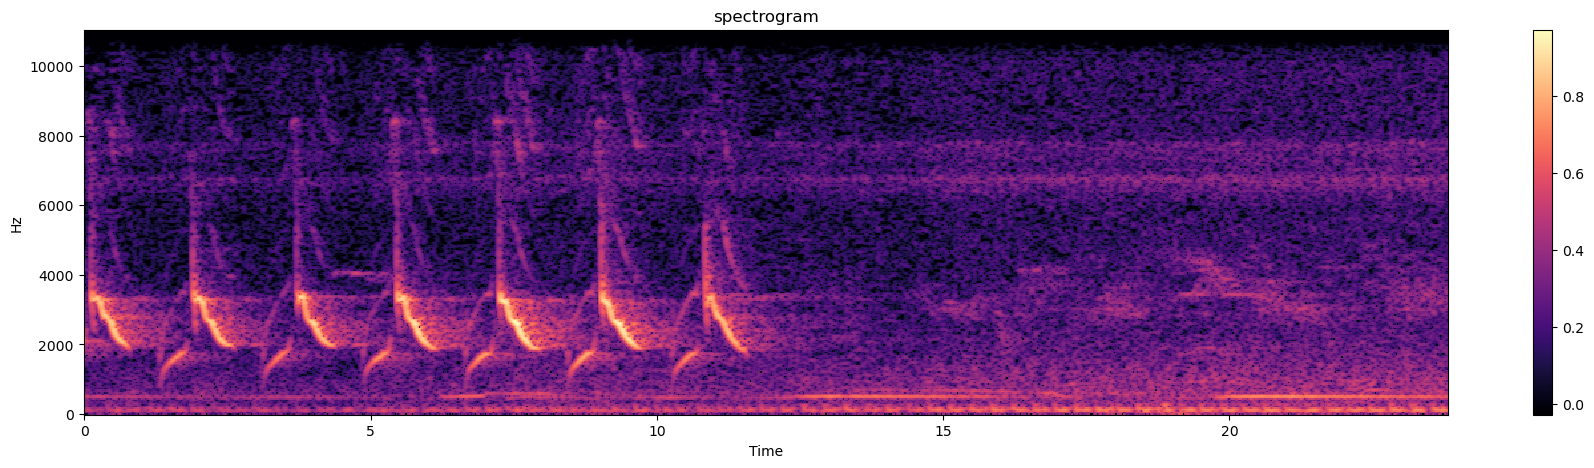

In [49]:
#Visualisation du spectogramme
for spectrograms,labels in dataset_train:
    plt.figure(figsize=(22,5))
    librosa.display.specshow(spectrograms[0].numpy().T,y_axis='linear', x_axis='time', cmap = 'magma')
    plt.colorbar()
    plt.title('spectrogram')
    plt.show()
    break

# Création du modèle

In [52]:
def create_model():


    #Cette couche d'entrée attend des données de forme (1026, 257), qui correspondent aux dimensions d'un spectrogramme audio avec 1026 frames et 257 caractéristiques (par exemple, des fréquences).
    inputs = Input((1026, 257), name = '0_Input_shape')

    
    #Conv1D(128, 8, 2) : Une couche de convolution 1D avec 128 filtres, une taille de filtre de 8, et un pas (stride) de 2.
    #activation='relu' : La fonction d'activation utilisée ici est la ReLU (Rectified Linear Unit), qui introduit de la non-linéarité.
    #padding='same' signifie que la dimension de sortie sera la même que celle d'entrée, en ajoutant du padding si nécessaire.
    #Spatial Dropout, est une méthode de régularisation pour éviter le sur-apprentissage. SpatialDropout1D(0.17) applique un dropout spatial (avec un taux de 0,17)
    x = Conv1D(128,8,2, activation='relu', padding='same', name = '1_Conv1D')(inputs)
    x = SpatialDropout1D(0.17, name = '2_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '3_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '4_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '5_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '6_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '7_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '8_SpatialDropout1D')(x)

    
    #GlobalAveragePooling1D applique un pooling global moyen, réduisant les dimensions en prenant la moyenne des activations le long de l'axe temporel. Cela résume l'information sans garder tous les détails, ce qui aide à simplifier les caractéristiques extraites.
    x = GlobalAveragePooling1D(name = '9_Global_avg_pooling')(x)
    x = Dense(512, activation='relu', name='10_Dense')(x)
    x = Dropout(0.5, name='11_Dropout')(x)

    #Dense(5) : La couche de sortie a 5 neurones,parce qu'il y a 5 classes d'oiseaux à prédire (si c'est une tâche de classification).
    outputs = Dense(5, name='12_Dense')(x)
    model = Model(inputs=inputs, outputs=outputs, name = 'Bird_audio_classification_model')

    return model

In [54]:
model = create_model()
model.summary()


Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Input_shape (InputLayer)  [(None, 1026, 257)]       0         
                                                                 
 1_Conv1D (Conv1D)           (None, 513, 128)          263296    
                                                                 
 2_SpatialDropout1D (Spatia  (None, 513, 128)          0         
 lDropout1D)                                                     
                                                                 
 3_Conv1d (Conv1D)           (None, 257, 128)          131200    
                                                                 
 4_SpatialDropout1D (Spatia  (None, 257, 128)          0         
 lDropout1D)                                                     
                                                                 
 5_Conv1d (Conv1D)           (None

## Compilation du modèle 

In [57]:
# le taux d'apprentissage initial à  0.001. C'est la vitesse à laquelle le modèle apprend au début de l'entraînement.
#e taux d'apprentissage doit être réduit tous les 4000 pas d'entraînement
#e taux d'apprentissage sera multiplié par  0.5 (c'est-à-dire réduit de moitié) après chaque période de decay_steps
#staircase=False : Avec False, le taux d'apprentissage diminuera de façon continue.
#name=None : Cela permet de donner un nom au plan d'apprentissage, mais ici il n'est pas spécifié.
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps= 4000, decay_rate = 0.5, staircase=False, name=None)


#loss=SparseCategoricalCrossentropy(from_logits=True) : La fonction de perte utilisée est la "cross-entropy" pour les problèmes de classification multiclasse,
#où les étiquettes sont sous forme d'entiers
model.compile(optimizer = Adam(lr_schedule),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = [ SparseCategoricalAccuracy()])

## Creating callbacks

In [60]:
# Creation callbacks
logdir = 'tb_logs/model'
tensorboard_callback = TensorBoard(log_dir=logdir)

checkpoint_filepath = 'model_checkpoint/model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

Ce code configure deux callbacks importants pour l'entraînement d'un modèle de deep learning :

TensorBoard pour visualiser l'apprentissage et le suivi des performances.
ModelCheckpoint pour sauvegarder le meilleur modèle basé sur la précision de validation, ce qui permet de revenir au meilleur état du modèle après l'entraînement. Cela est particulièrement utile pour éviter le sur-apprentissage (overfitting) et pour garantir que le modèle retenu est celui qui a montré la meilleure performance sur les données de validation.

## Entrainement du modèle

In [67]:
training = model.fit(dataset_train, validation_data = dataset_val, epochs=50,
                     callbacks=[tensorboard_callback,model_checkpoint_callback])

Epoch 1/50
152/152 [==============================] - ETA: 0s - loss: 1.0565 - sparse_categorical_accuracy: 0.5350INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 114ms/step - loss: 1.0565 - sparse_categorical_accuracy: 0.5350 - val_loss: 0.9359 - val_sparse_categorical_accuracy: 0.5938
Epoch 2/50
152/152 [==============================] - 16s 107ms/step - loss: 0.9712 - sparse_categorical_accuracy: 0.5921 - val_loss: 0.9785 - val_sparse_categorical_accuracy: 0.5645
Epoch 3/50
152/152 [==============================] - ETA: 0s - loss: 0.9287 - sparse_categorical_accuracy: 0.6088INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 113ms/step - loss: 0.9287 - sparse_categorical_accuracy: 0.6088 - val_loss: 0.8877 - val_sparse_categorical_accuracy: 0.6230
Epoch 4/50
152/152 [==============================] - ETA: 0s - loss: 0.9020 - sparse_categorical_accuracy: 0.6242INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 19s 126ms/step - loss: 0.9020 - sparse_categorical_accuracy: 0.6242 - val_loss: 0.8391 - val_sparse_categorical_accuracy: 0.6387
Epoch 5/50
152/152 [==============================] - 16s 108ms/step - loss: 0.8396 - sparse_categorical_accuracy: 0.6519 - val_loss: 0.8528 - val_sparse_categorical_accuracy: 0.6289
Epoch 6/50
152/152 [==============================] - ETA: 0s - loss: 0.8179 - sparse_categorical_accuracy: 0.6674INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 18s 119ms/step - loss: 0.8179 - sparse_categorical_accuracy: 0.6674 - val_loss: 0.7328 - val_sparse_categorical_accuracy: 0.6758
Epoch 7/50
152/152 [==============================] - ETA: 0s - loss: 0.8054 - sparse_categorical_accuracy: 0.6801INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 18s 116ms/step - loss: 0.8054 - sparse_categorical_accuracy: 0.6801 - val_loss: 0.6863 - val_sparse_categorical_accuracy: 0.7012
Epoch 8/50
152/152 [==============================] - ETA: 0s - loss: 0.7540 - sparse_categorical_accuracy: 0.7035INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 19s 125ms/step - loss: 0.7540 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.6576 - val_sparse_categorical_accuracy: 0.7344
Epoch 9/50
152/152 [==============================] - ETA: 0s - loss: 0.7067 - sparse_categorical_accuracy: 0.7253INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 18s 116ms/step - loss: 0.7067 - sparse_categorical_accuracy: 0.7253 - val_loss: 0.6031 - val_sparse_categorical_accuracy: 0.7715
Epoch 10/50
152/152 [==============================] - ETA: 0s - loss: 0.6825 - sparse_categorical_accuracy: 0.7344INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 114ms/step - loss: 0.6825 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.5803 - val_sparse_categorical_accuracy: 0.7969
Epoch 11/50
152/152 [==============================] - 16s 107ms/step - loss: 0.6665 - sparse_categorical_accuracy: 0.7412 - val_loss: 0.5517 - val_sparse_categorical_accuracy: 0.7910
Epoch 12/50
152/152 [==============================] - ETA: 0s - loss: 0.6232 - sparse_categorical_accuracy: 0.7617INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 109ms/step - loss: 0.6232 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.5439 - val_sparse_categorical_accuracy: 0.8145
Epoch 13/50
152/152 [==============================] - 16s 106ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.5329 - val_sparse_categorical_accuracy: 0.8105
Epoch 14/50
152/152 [==============================] - ETA: 0s - loss: 0.6057 - sparse_categorical_accuracy: 0.7681INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 114ms/step - loss: 0.6057 - sparse_categorical_accuracy: 0.7681 - val_loss: 0.4824 - val_sparse_categorical_accuracy: 0.8398
Epoch 15/50
152/152 [==============================] - 16s 104ms/step - loss: 0.5487 - sparse_categorical_accuracy: 0.7961 - val_loss: 0.4506 - val_sparse_categorical_accuracy: 0.8262
Epoch 16/50
152/152 [==============================] - ETA: 0s - loss: 0.5410 - sparse_categorical_accuracy: 0.7930INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 19s 125ms/step - loss: 0.5410 - sparse_categorical_accuracy: 0.7930 - val_loss: 0.4069 - val_sparse_categorical_accuracy: 0.8613
Epoch 17/50
152/152 [==============================] - 17s 110ms/step - loss: 0.5106 - sparse_categorical_accuracy: 0.8078 - val_loss: 0.3967 - val_sparse_categorical_accuracy: 0.8418
Epoch 18/50
152/152 [==============================] - ETA: 0s - loss: 0.5219 - sparse_categorical_accuracy: 0.8051INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 114ms/step - loss: 0.5219 - sparse_categorical_accuracy: 0.8051 - val_loss: 0.3811 - val_sparse_categorical_accuracy: 0.8691
Epoch 19/50
152/152 [==============================] - 16s 105ms/step - loss: 0.4730 - sparse_categorical_accuracy: 0.8183 - val_loss: 0.3919 - val_sparse_categorical_accuracy: 0.8574
Epoch 20/50
152/152 [==============================] - ETA: 0s - loss: 0.4668 - sparse_categorical_accuracy: 0.8246INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 109ms/step - loss: 0.4668 - sparse_categorical_accuracy: 0.8246 - val_loss: 0.3348 - val_sparse_categorical_accuracy: 0.8770
Epoch 21/50
152/152 [==============================] - 16s 103ms/step - loss: 0.4569 - sparse_categorical_accuracy: 0.8285 - val_loss: 0.3390 - val_sparse_categorical_accuracy: 0.8750
Epoch 22/50
152/152 [==============================] - 16s 102ms/step - loss: 0.4376 - sparse_categorical_accuracy: 0.8398 - val_loss: 0.3388 - val_sparse_categorical_accuracy: 0.8770
Epoch 23/50
152/152 [==============================] - ETA: 0s - loss: 0.4282 - sparse_categorical_accuracy: 0.8481INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 18s 119ms/step - loss: 0.4282 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.3208 - val_sparse_categorical_accuracy: 0.8926
Epoch 24/50
152/152 [==============================] - 16s 108ms/step - loss: 0.4151 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.3137 - val_sparse_categorical_accuracy: 0.8809
Epoch 25/50
152/152 [==============================] - 17s 109ms/step - loss: 0.4066 - sparse_categorical_accuracy: 0.8429 - val_loss: 0.3212 - val_sparse_categorical_accuracy: 0.8789
Epoch 26/50
152/152 [==============================] - ETA: 0s - loss: 0.3758 - sparse_categorical_accuracy: 0.8604INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 114ms/step - loss: 0.3758 - sparse_categorical_accuracy: 0.8604 - val_loss: 0.2947 - val_sparse_categorical_accuracy: 0.8945
Epoch 27/50
152/152 [==============================] - ETA: 0s - loss: 0.3888 - sparse_categorical_accuracy: 0.8610INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 18s 119ms/step - loss: 0.3888 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.2760 - val_sparse_categorical_accuracy: 0.9043
Epoch 28/50
152/152 [==============================] - ETA: 0s - loss: 0.3719 - sparse_categorical_accuracy: 0.8612INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 18s 116ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.2670 - val_sparse_categorical_accuracy: 0.9102
Epoch 29/50
152/152 [==============================] - 17s 109ms/step - loss: 0.3712 - sparse_categorical_accuracy: 0.8657 - val_loss: 0.2479 - val_sparse_categorical_accuracy: 0.9082
Epoch 30/50
152/152 [==============================] - ETA: 0s - loss: 0.3470 - sparse_categorical_accuracy: 0.8717INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 113ms/step - loss: 0.3470 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.2063 - val_sparse_categorical_accuracy: 0.9277
Epoch 31/50
152/152 [==============================] - 18s 115ms/step - loss: 0.3508 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.2217 - val_sparse_categorical_accuracy: 0.9219
Epoch 32/50
152/152 [==============================] - 17s 112ms/step - loss: 0.3271 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.2304 - val_sparse_categorical_accuracy: 0.9199
Epoch 33/50
152/152 [==============================] - 18s 117ms/step - loss: 0.3353 - sparse_categorical_accuracy: 0.8822 - val_loss: 0.2354 - val_sparse_categorical_accuracy: 0.9238
Epoch 34/50
152/152 [==============================] - ETA: 0s - loss: 0.3054 - sparse_categorical_accuracy: 0.8929INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 18s 119ms/step - loss: 0.3054 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.1776 - val_sparse_categorical_accuracy: 0.9531
Epoch 35/50
152/152 [==============================] - 18s 115ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.1950 - val_sparse_categorical_accuracy: 0.9297
Epoch 36/50
152/152 [==============================] - 18s 118ms/step - loss: 0.2965 - sparse_categorical_accuracy: 0.8902 - val_loss: 0.2147 - val_sparse_categorical_accuracy: 0.9355
Epoch 37/50
152/152 [==============================] - 17s 113ms/step - loss: 0.2979 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.1921 - val_sparse_categorical_accuracy: 0.9414
Epoch 38/50
152/152 [==============================] - 17s 114ms/step - loss: 0.2788 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.1875 - val_sparse_categorical_accuracy: 0.9355
Epoch 39/50
152/152 [==============================] - 17s 111ms/step - loss: 0.2764 - spars

INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 16s 108ms/step - loss: 0.2306 - sparse_categorical_accuracy: 0.9147 - val_loss: 0.1458 - val_sparse_categorical_accuracy: 0.9570
Epoch 48/50
152/152 [==============================] - 16s 105ms/step - loss: 0.2208 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.1426 - val_sparse_categorical_accuracy: 0.9512
Epoch 49/50
152/152 [==============================] - ETA: 0s - loss: 0.2218 - sparse_categorical_accuracy: 0.9200INFO:tensorflow:Assets written to: model_checkpoint\model\assets


INFO:tensorflow:Assets written to: model_checkpoint\model\assets


152/152 [==============================] - 17s 110ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.1306 - val_sparse_categorical_accuracy: 0.9629
Epoch 50/50
152/152 [==============================] - 16s 102ms/step - loss: 0.2373 - sparse_categorical_accuracy: 0.9188 - val_loss: 0.1464 - val_sparse_categorical_accuracy: 0.9512


# Evaluation du modèle

In [71]:
# Récupérer les données d'accuracy et de validation
acc = training.history['sparse_categorical_accuracy']
val_acc = training.history['val_sparse_categorical_accuracy']

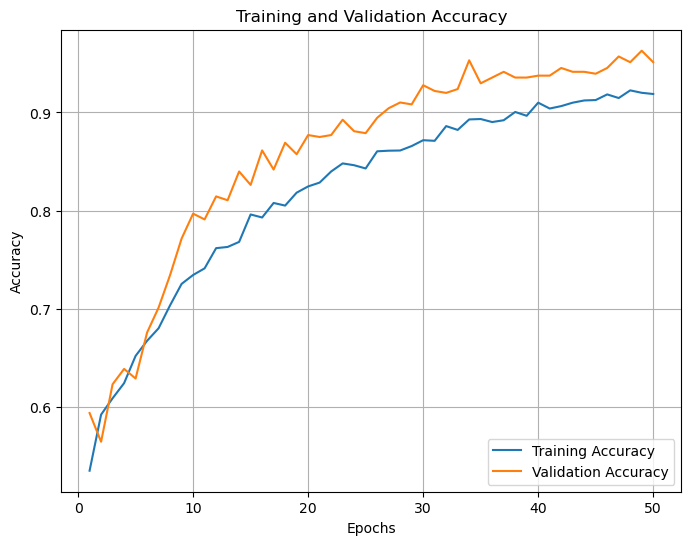

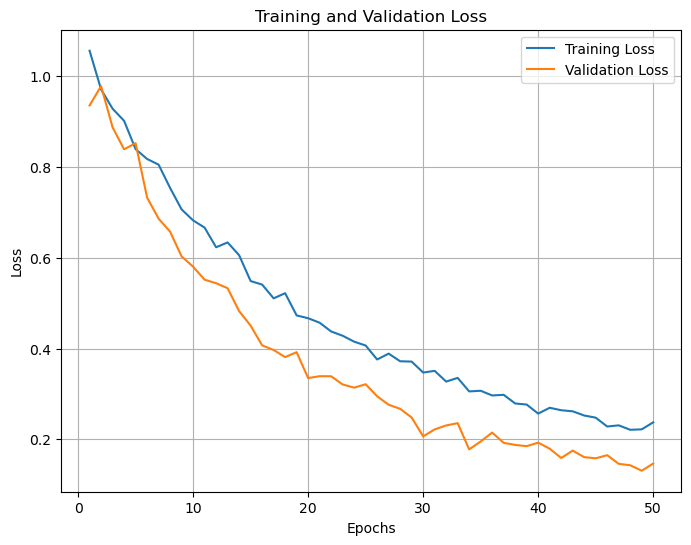

In [73]:
# Récupérer les données de loss (facultatif si tu veux aussi les visualiser)
loss = training.history['loss']
val_loss = training.history['val_loss']

# Tracer la courbe d'accuracy
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Facultatif : pour afficher la courbe de loss aussi
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [77]:
model.evaluate(dataset_val, return_dict=True)

16/16 [==============================] - 1s 53ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.9512


{'loss': 0.14639489352703094, 'sparse_categorical_accuracy': 0.951171875}

In [81]:
y_logits = model.predict(dataset_val)
y_prob = tf.nn.softmax(y_logits, axis=1)
y_pred = tf.argmax(y_logits, axis=1)
y_true = tf.concat(list(dataset_val.map(lambda s,lab: lab)), axis=0)

16/16 [==============================] - 1s 50ms/step


In [83]:
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovo')
print(f"F1: {f1} | Precision: {precision} | Recall: {recall} | AUC: {auc}")

F1: 0.9510736108330955 | Precision: 0.9504173755284869 | Recall: 0.9524755155991809 | AUC: 0.9979307755194758


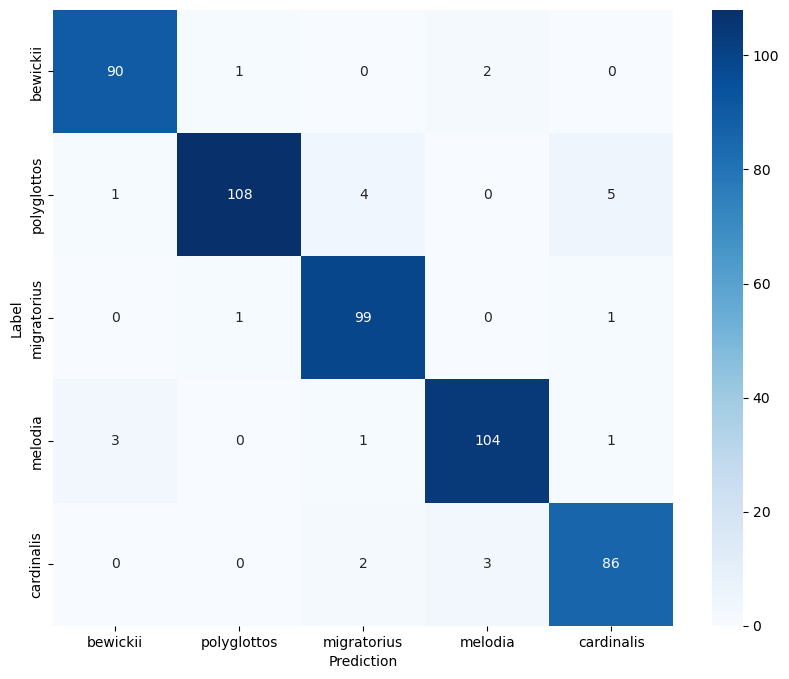

In [85]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            yticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            annot=True, fmt='g', cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
